<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/Lab1%20MD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMPARISON OF EXPONENTIAL VS DETERMINISTIC SERVICE TIMES

1. EXPONENTIAL SERVICE TIMES (M/M/1)
Average Queue Length: (np.float64(8.98059290291939), np.float64(1.395580370075543))
Average Waiting Time: (np.float64(0.5992209191069134), np.float64(0.09101867193603831))

Detailed Analysis (M/M/1):
Traffic intensity ρ: 0.900
Service type: exponential
Observations: 2994610, Total time: 99871.5 min

System Size (L):
  Empirical: mean=8.981, var=88.927
  Theoretical: mean=9.000, var=90.000

Queue Length (Lq):
  Empirical: mean=8.081, var=87.210
  Theoretical: mean=8.100, var=88.290
Probability(W > 3 minutes): 0.006466
Theoretical P(W > 3 minutes): 6.064152e-03

2. DETERMINISTIC SERVICE TIMES (M/D/1)
Average Queue Length: (np.float64(4.933188637169987), np.float64(0.5046197454949842))
Average Waiting Time: (np.float64(0.32906743386281817), np.float64(0.03170265230853432))

Detailed Analysis (M/D/1):
Traffic intensity ρ: 0.900
Service type: deterministic
Observations: 2993428, Total time: 99842.

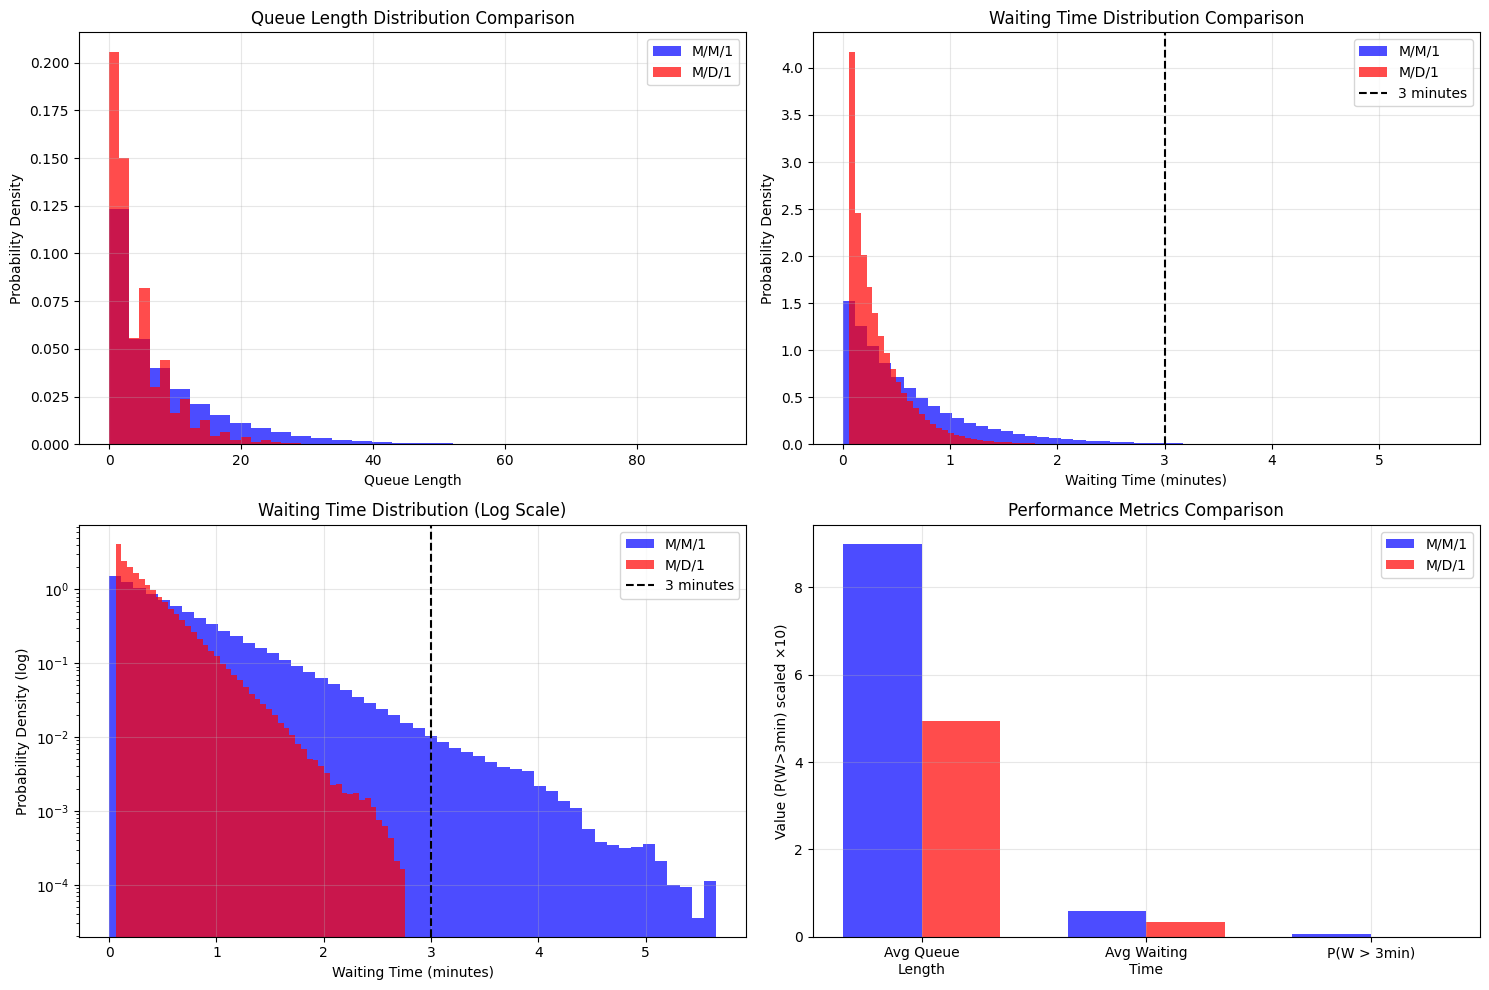

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class SingleServerQueueingSimulation():
    """
    This class simulates a single-server queueing system using discrete event simulation.
    The system models customer arrivals and service at a single server.
    It collects data on queue length, arrival times, and departure times.
    """

    def __init__(self, arrival_rate, service_rate, close_time, service_type='exponential'):
        """
        Initializes the simulation with the given parameters.

        Parameters:
        - arrival_rate: The rate (per minute) at which customers arrive.
        - service_rate: The rate (per minute) at which the server can serve customers.
        - close_time: The time (in minutes) after which no new customers are allowed to join the queue.
        - service_type: 'exponential' for exponential service times, 'deterministic' for constant service times
        """
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.close_time = close_time
        self.service_type = service_type

        self.generate_interarrival_time = lambda: np.random.exponential(1 / self.arrival_rate)

        if service_type == 'exponential':
            self.generate_service_time = lambda: np.random.exponential(1 / self.service_rate)
        elif service_type == 'deterministic':
            self.generate_service_time = lambda: 1 / self.service_rate  # Constant service time
        else:
            raise ValueError("service_type must be 'exponential' or 'deterministic'")

        self.simulation_records = {}

    def simulate(self):
        # Initialize simulation state variables
        t = 0
        N_arrivals = 0
        N_departures = 0
        n = 0

        # Generate first arrival time
        X = self.generate_interarrival_time()
        t_arrival = t + X
        t_departure = float('inf')

        # Lists to record queue length, arrival times, and departure times
        queue = []
        A = []
        D = []

        # Main simulation loop to process events (arrivals or departures)
        while True:
            # Case 1: A customer arrives before the next departure and before the system closes
            if t_arrival <= t_departure and t_arrival <= self.close_time:
                t = t_arrival
                n += 1
                queue.append([n, t])
                N_arrivals += 1
                A.append([N_arrivals, t])
                t_arrival = t + self.generate_interarrival_time()
                if n == 1:
                    t_departure = t + self.generate_service_time()

            # Case 2: A customer departs before the next arrival and before the system closes
            elif t_departure < t_arrival and t_departure <= self.close_time:
                t = t_departure
                n -= 1
                queue.append([n, t])
                N_departures += 1
                D.append([N_departures, t])
                if n == 0:
                    t_departure = float('inf')
                else:
                    t_departure = t + self.generate_service_time()

            # Case 3: Stop the simulation if there are no more arrivals or departures
            elif t_arrival > self.close_time and t_departure > self.close_time:
                if n == 0:
                    break
                if n > 0:
                    t = t_departure
                    n -= 1
                    queue.append([n, t])
                    N_departures += 1
                    D.append([N_departures, t])
                    if n > 0:
                        t_departure = t + self.generate_service_time()
                    else:
                        break
            else:
                break

        # Convert lists to NumPy arrays for easier manipulation and analysis
        queue = np.array(queue)
        A = np.array(A)
        D = np.array(D)
        return queue, A, D

    def run_multiple_simulations(self, n_simulations):
        for i in range(n_simulations):
            queue, A, D = self.simulate()
            self.simulation_records[f"round_{i}"] = {'queue': queue, 'A': A, 'D': D}
        return

    def compute_average_queue_length(self):
        warm_up_period = 50
        average_queue_length = []
        for values in self.simulation_records.values():
            queue = values['queue'][warm_up_period:]
            if len(queue) < 2:
                continue
            times = queue[:, 1]
            lengths = queue[:, 0]
            time_deltas = np.diff(times)
            queue_lengths = lengths[:-1]
            weighted_sum = np.sum(queue_lengths * time_deltas)
            total_time = np.sum(time_deltas)
            queue_length = weighted_sum / total_time if total_time > 0 else 0
            average_queue_length.append(queue_length)
        return np.mean(average_queue_length), np.std(average_queue_length)

    def compute_average_waiting_time(self):
        warm_up_period = 50
        average_waiting_time = []
        for values in self.simulation_records.values():
            A = values['A'][warm_up_period:]
            D = values['D'][warm_up_period:]
            if len(A) == 0 or len(D) == 0:
                continue
            arrival_times = A[:, 1]
            departure_times = D[:, 1]
            waiting_times = departure_times - arrival_times
            avg_wait = np.mean(waiting_times)
            average_waiting_time.append(avg_wait)
        return np.mean(average_waiting_time), np.std(average_waiting_time)

    def analyze_queue_length_distribution(self):
        """Analyze queue length distribution across all simulations"""
        warm_up_period = 50
        time_weighted_queue_lengths = []
        time_weighted_system_sizes = []
        time_intervals = []

        for values in self.simulation_records.values():
            queue = values['queue'][warm_up_period:]

            if len(queue) < 2:
                continue

            times = queue[:, 1]
            system_sizes = queue[:, 0]  # This is n = number in system
            queue_lengths = np.maximum(0, system_sizes - 1)  # Queue length excludes the one in service

            time_deltas = np.diff(times)
            system_sizes_for_intervals = system_sizes[:-1]
            queue_lengths_for_intervals = queue_lengths[:-1]

            # Proper time-weighted collection
            for sys_size, q_length, delta in zip(system_sizes_for_intervals, queue_lengths_for_intervals, time_deltas):
                if delta > 0:
                    time_weighted_system_sizes.append(sys_size)
                    time_weighted_queue_lengths.append(q_length)
                    time_intervals.append(delta)

        # Convert to arrays
        time_weighted_system_sizes = np.array(time_weighted_system_sizes)
        time_weighted_queue_lengths = np.array(time_weighted_queue_lengths)
        time_intervals = np.array(time_intervals)

        # Calculate weighted statistics
        total_time = np.sum(time_intervals)
        weights = time_intervals / total_time

        # System size statistics
        weighted_mean_system = np.sum(time_weighted_system_sizes * weights)
        weighted_var_system = np.sum(weights * (time_weighted_system_sizes - weighted_mean_system)**2)

        # Queue length statistics
        weighted_mean_queue = np.sum(time_weighted_queue_lengths * weights)
        weighted_var_queue = np.sum(weights * (time_weighted_queue_lengths - weighted_mean_queue)**2)

        # Theoretical values
        rho = self.arrival_rate / self.service_rate

        # Different theoretical formulas based on service type
        if self.service_type == 'exponential':
            # M/M/1 queue
            theoretical_mean_system = rho / (1 - rho)
            theoretical_mean_queue = (rho**2) / (1 - rho)
            theoretical_var_system = rho / ((1 - rho)**2)
            theoretical_var_queue = (rho**2 * (1 + rho - rho**2)) / ((1 - rho)**2)
            queue_type = "M/M/1"
        else:
            # M/D/1 queue
            theoretical_mean_system = rho + (rho**2) / (2 * (1 - rho))
            theoretical_mean_queue = (rho**2) / (2 * (1 - rho))
            # For M/D/1, variance formulas are more complex - using approximation
            theoretical_var_system = rho * (2 - rho) / (2 * (1 - rho)**2)  # Approximation
            theoretical_var_queue = (rho**2 * (4 - 3 * rho + rho**2)) / (12 * (1 - rho)**2)  # Approximation
            queue_type = "M/D/1"

        print(f"\nDetailed Analysis ({queue_type}):")
        print(f"Traffic intensity ρ: {rho:.3f}")
        print(f"Service type: {self.service_type}")
        print(f"Observations: {len(time_weighted_queue_lengths)}, Total time: {total_time:.1f} min")
        print(f"\nSystem Size (L):")
        print(f"  Empirical: mean={weighted_mean_system:.3f}, var={weighted_var_system:.3f}")
        print(f"  Theoretical: mean={theoretical_mean_system:.3f}, var={theoretical_var_system:.3f}")
        print(f"\nQueue Length (Lq):")
        print(f"  Empirical: mean={weighted_mean_queue:.3f}, var={weighted_var_queue:.3f}")
        print(f"  Theoretical: mean={theoretical_mean_queue:.3f}, var={theoretical_var_queue:.3f}")

        return weighted_var_queue, theoretical_var_queue, time_weighted_queue_lengths

    def analyze_waiting_time_distribution(self):
        """Analyze waiting time distribution across all simulations"""
        warm_up_period = 50
        all_waiting_times = []

        for values in self.simulation_records.values():
            A = values['A'][warm_up_period:]
            D = values['D'][warm_up_period:]

            if len(A) == 0 or len(D) == 0:
                continue

            arrival_times = A[:, 1]
            departure_times = D[:len(arrival_times), 1]

            waiting_times = departure_times - arrival_times
            all_waiting_times.extend(waiting_times)

        all_waiting_times = np.array(all_waiting_times)
        waiting_times_seconds = all_waiting_times * 60
        prob_wait_gt_3min = np.mean(waiting_times_seconds > 180)

        # Theoretical probability calculation
        rho = self.arrival_rate / self.service_rate
        if self.service_type == 'exponential':
            # M/M/1: P(W > t) = ρ * exp(-μ(1-ρ)t)
            theoretical_prob = rho * np.exp(-self.service_rate * (1 - rho) * 3)
        else:
            # M/D/1: More complex formula, using approximation
            # For M/D/1, waiting time distribution doesn't have a simple closed form
            theoretical_prob = "N/A (complex calculation)"

        return all_waiting_times, prob_wait_gt_3min, theoretical_prob

    def plot_queue_length_distribution(self, all_queue_lengths):
        """Plots the distribution of queue lengths."""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(all_queue_lengths, bins=50, density=True, alpha=0.7, color='skyblue')
        plt.title(f'Distribution of Queue Lengths ({self.service_type} service)')
        plt.xlabel('Queue Length')
        plt.ylabel('Probability Density')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        unique_lengths, counts = np.unique(all_queue_lengths, return_counts=True)
        probabilities = counts / len(all_queue_lengths)
        plt.bar(unique_lengths, probabilities, alpha=0.7, color='lightcoral')
        plt.title(f'PMF of Queue Lengths ({self.service_type} service)')
        plt.xlabel('Queue Length')
        plt.ylabel('Probability')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_waiting_time_distribution(self, all_waiting_times):
        """Plots the distribution of waiting times."""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(all_waiting_times, bins=50, density=True, alpha=0.7, color='lightgreen')
        plt.title(f'Distribution of Waiting Times ({self.service_type} service)')
        plt.xlabel('Waiting Time (minutes)')
        plt.ylabel('Probability Density')
        plt.axvline(x=3, color='red', linestyle='--', label='3 minutes')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.hist(all_waiting_times, bins=50, density=True, alpha=0.7, color='orange', log=True)
        plt.title(f'Waiting Times Distribution ({self.service_type} service, Log Scale)')
        plt.xlabel('Waiting Time (minutes)')
        plt.ylabel('Probability Density (log)')
        plt.axvline(x=3, color='red', linestyle='--', label='3 minutes')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def get_simulation_records(self):
        return self.simulation_records


# Comparison of different service types with same λ/μ ratio
def compare_service_types():
    arrival_rate = 15
    service_rate = 16.66666666666666667  # Same as your example
    close_time = 1000

    print("=" * 60)
    print("COMPARISON OF EXPONENTIAL VS DETERMINISTIC SERVICE TIMES")
    print("=" * 60)

    # Exponential service (M/M/1)
    print("\n1. EXPONENTIAL SERVICE TIMES (M/M/1)")
    sim_exp = SingleServerQueueingSimulation(arrival_rate=arrival_rate,
                                           service_rate=service_rate,
                                           close_time=close_time,
                                           service_type='exponential')
    sim_exp.run_multiple_simulations(100)

    print("Average Queue Length:", sim_exp.compute_average_queue_length())
    print("Average Waiting Time:", sim_exp.compute_average_waiting_time())

    empirical_var_exp, theoretical_var_exp, all_queues_exp = sim_exp.analyze_queue_length_distribution()
    all_waits_exp, prob_gt_3min_exp, theoretical_prob_exp = sim_exp.analyze_waiting_time_distribution()

    print(f"Probability(W > 3 minutes): {prob_gt_3min_exp:.6f}")
    if theoretical_prob_exp != "N/A":
        print(f"Theoretical P(W > 3 minutes): {theoretical_prob_exp:.6e}")

    # Deterministic service (M/D/1)
    print("\n2. DETERMINISTIC SERVICE TIMES (M/D/1)")
    sim_det = SingleServerQueueingSimulation(arrival_rate=arrival_rate,
                                           service_rate=service_rate,
                                           close_time=close_time,
                                           service_type='deterministic')
    sim_det.run_multiple_simulations(100)

    print("Average Queue Length:", sim_det.compute_average_queue_length())
    print("Average Waiting Time:", sim_det.compute_average_waiting_time())

    empirical_var_det, theoretical_var_det, all_queues_det = sim_det.analyze_queue_length_distribution()
    all_waits_det, prob_gt_3min_det, theoretical_prob_det = sim_det.analyze_waiting_time_distribution()

    print(f"Probability(W > 3 minutes): {prob_gt_3min_det:.6f}")
    if theoretical_prob_det != "N/A":
        print(f"Theoretical P(W > 3 minutes): {theoretical_prob_det}")

    # Summary comparison
    print("\n" + "=" * 60)
    print("SUMMARY COMPARISON")
    print("=" * 60)
    rho = arrival_rate / service_rate
    print(f"Traffic intensity ρ: {rho:.3f}")
    print(f"Mean service time: {1/service_rate:.3f} minutes")
    print("\nPerformance Metrics:")
    print(f"{'Metric':<25} {'M/M/1':<10} {'M/D/1':<10} {'Improvement':<15}")
    print(f"{'-'*25} {'-'*10} {'-'*10} {'-'*15}")

    avg_q_exp = sim_exp.compute_average_queue_length()[0]
    avg_q_det = sim_det.compute_average_queue_length()[0]
    improvement_q = (avg_q_exp - avg_q_det) / avg_q_exp * 100
    print(f"{'Avg Queue Length':<25} {avg_q_exp:<10.3f} {avg_q_det:<10.3f} {improvement_q:<15.1f}%")

    avg_w_exp = sim_exp.compute_average_waiting_time()[0]
    avg_w_det = sim_det.compute_average_waiting_time()[0]
    improvement_w = (avg_w_exp - avg_w_det) / avg_w_exp * 100
    print(f"{'Avg Waiting Time':<25} {avg_w_exp:<10.3f} {avg_w_det:<10.3f} {improvement_w:<15.1f}%")

    print(f"{'P(W > 3min)':<25} {prob_gt_3min_exp:<10.6f} {prob_gt_3min_det:<10.6f} {'N/A':<15}")

    # Plot comparisons
    plt.figure(figsize=(15, 10))

    # Queue length comparison
    plt.subplot(2, 2, 1)
    plt.hist(all_queues_exp, bins=30, density=True, alpha=0.7, label='M/M/1', color='blue')
    plt.hist(all_queues_det, bins=30, density=True, alpha=0.7, label='M/D/1', color='red')
    plt.title('Queue Length Distribution Comparison')
    plt.xlabel('Queue Length')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Waiting time comparison
    plt.subplot(2, 2, 2)
    plt.hist(all_waits_exp, bins=50, density=True, alpha=0.7, label='M/M/1', color='blue')
    plt.hist(all_waits_det, bins=50, density=True, alpha=0.7, label='M/D/1', color='red')
    plt.title('Waiting Time Distribution Comparison')
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Probability Density')
    plt.axvline(x=3, color='black', linestyle='--', label='3 minutes')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Waiting time log scale
    plt.subplot(2, 2, 3)
    plt.hist(all_waits_exp, bins=50, density=True, alpha=0.7, label='M/M/1', color='blue', log=True)
    plt.hist(all_waits_det, bins=50, density=True, alpha=0.7, label='M/D/1', color='red', log=True)
    plt.title('Waiting Time Distribution (Log Scale)')
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Probability Density (log)')
    plt.axvline(x=3, color='black', linestyle='--', label='3 minutes')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Performance metrics bar chart
    plt.subplot(2, 2, 4)
    metrics = ['Avg Queue\nLength', 'Avg Waiting\nTime', 'P(W > 3min)']
    mm1_values = [avg_q_exp, avg_w_exp, prob_gt_3min_exp * 10]  # Scale probability for visibility
    md1_values = [avg_q_det, avg_w_det, prob_gt_3min_det * 10]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, mm1_values, width, label='M/M/1', color='blue', alpha=0.7)
    plt.bar(x + width/2, md1_values, width, label='M/D/1', color='red', alpha=0.7)
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics)
    plt.ylabel('Value (P(W>3min) scaled ×10)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return sim_exp, sim_det

# Run the comparison
if __name__ == "__main__":
    sim_exp, sim_det = compare_service_types()

COMPARISON OF EXPONENTIAL VS DETERMINISTIC SERVICE TIMES

1. EXPONENTIAL SERVICE TIMES (M/M/1)
Average Queue Length: (np.float64(1.4995002947880545), np.float64(0.0563012892600108))
Average Waiting Time: (np.float64(0.10005913625130777), np.float64(0.003474581139944764))

Detailed Analysis (M/M/1):
Traffic intensity ρ: 0.600
Service type: exponential
Observations: 2992042, Total time: 99826.1 min

System Size (L):
  Empirical: mean=1.499, var=3.765
  Theoretical: mean=1.500, var=3.750

Queue Length (Lq):
  Empirical: mean=0.899, var=2.805
  Theoretical: mean=0.900, var=2.790
Probability(W > 3 minutes): 0.000000
Theoretical P(W > 3 minutes): 5.614574e-14

2. DETERMINISTIC SERVICE TIMES (M/D/1)
Average Queue Length: (np.float64(1.0506383261413097), np.float64(0.018072133053032235))
Average Waiting Time: (np.float64(0.07003708801714494), np.float64(0.0008819276770508466))

Detailed Analysis (M/D/1):
Traffic intensity ρ: 0.600
Service type: deterministic
Observations: 2994886, Total time: 

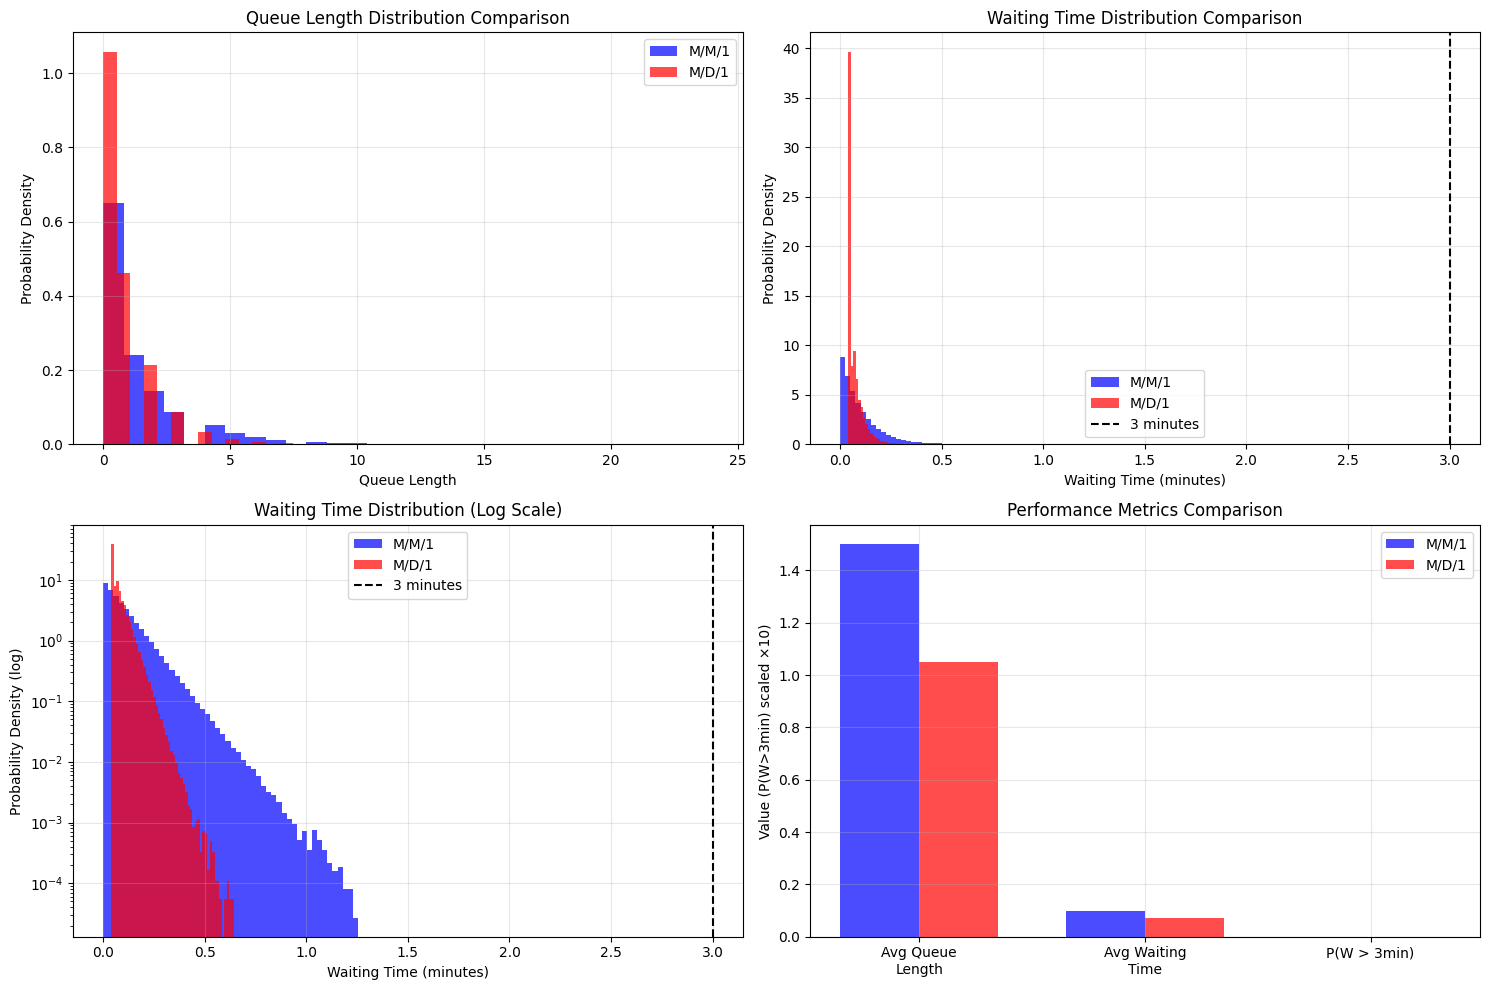

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class SingleServerQueueingSimulation():
    """
    This class simulates a single-server queueing system using discrete event simulation.
    The system models customer arrivals and service at a single server.
    It collects data on queue length, arrival times, and departure times.
    """

    def __init__(self, arrival_rate, service_rate, close_time, service_type='exponential'):
        """
        Initializes the simulation with the given parameters.

        Parameters:
        - arrival_rate: The rate (per minute) at which customers arrive.
        - service_rate: The rate (per minute) at which the server can serve customers.
        - close_time: The time (in minutes) after which no new customers are allowed to join the queue.
        - service_type: 'exponential' for exponential service times, 'deterministic' for constant service times
        """
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.close_time = close_time
        self.service_type = service_type

        self.generate_interarrival_time = lambda: np.random.exponential(1 / self.arrival_rate)

        if service_type == 'exponential':
            self.generate_service_time = lambda: np.random.exponential(1 / self.service_rate)
        elif service_type == 'deterministic':
            self.generate_service_time = lambda: 1 / self.service_rate  # Constant service time
        else:
            raise ValueError("service_type must be 'exponential' or 'deterministic'")

        self.simulation_records = {}

    def simulate(self):
        # Initialize simulation state variables
        t = 0
        N_arrivals = 0
        N_departures = 0
        n = 0

        # Generate first arrival time
        X = self.generate_interarrival_time()
        t_arrival = t + X
        t_departure = float('inf')

        # Lists to record queue length, arrival times, and departure times
        queue = []
        A = []
        D = []

        # Main simulation loop to process events (arrivals or departures)
        while True:
            # Case 1: A customer arrives before the next departure and before the system closes
            if t_arrival <= t_departure and t_arrival <= self.close_time:
                t = t_arrival
                n += 1
                queue.append([n, t])
                N_arrivals += 1
                A.append([N_arrivals, t])
                t_arrival = t + self.generate_interarrival_time()
                if n == 1:
                    t_departure = t + self.generate_service_time()

            # Case 2: A customer departs before the next arrival and before the system closes
            elif t_departure < t_arrival and t_departure <= self.close_time:
                t = t_departure
                n -= 1
                queue.append([n, t])
                N_departures += 1
                D.append([N_departures, t])
                if n == 0:
                    t_departure = float('inf')
                else:
                    t_departure = t + self.generate_service_time()

            # Case 3: Stop the simulation if there are no more arrivals or departures
            elif t_arrival > self.close_time and t_departure > self.close_time:
                if n == 0:
                    break
                if n > 0:
                    t = t_departure
                    n -= 1
                    queue.append([n, t])
                    N_departures += 1
                    D.append([N_departures, t])
                    if n > 0:
                        t_departure = t + self.generate_service_time()
                    else:
                        break
            else:
                break

        # Convert lists to NumPy arrays for easier manipulation and analysis
        queue = np.array(queue)
        A = np.array(A)
        D = np.array(D)
        return queue, A, D

    def run_multiple_simulations(self, n_simulations):
        for i in range(n_simulations):
            queue, A, D = self.simulate()
            self.simulation_records[f"round_{i}"] = {'queue': queue, 'A': A, 'D': D}
        return

    def compute_average_queue_length(self):
        warm_up_period = 50
        average_queue_length = []
        for values in self.simulation_records.values():
            queue = values['queue'][warm_up_period:]
            if len(queue) < 2:
                continue
            times = queue[:, 1]
            lengths = queue[:, 0]
            time_deltas = np.diff(times)
            queue_lengths = lengths[:-1]
            weighted_sum = np.sum(queue_lengths * time_deltas)
            total_time = np.sum(time_deltas)
            queue_length = weighted_sum / total_time if total_time > 0 else 0
            average_queue_length.append(queue_length)
        return np.mean(average_queue_length), np.std(average_queue_length)

    def compute_average_waiting_time(self):
        warm_up_period = 50
        average_waiting_time = []
        for values in self.simulation_records.values():
            A = values['A'][warm_up_period:]
            D = values['D'][warm_up_period:]
            if len(A) == 0 or len(D) == 0:
                continue
            arrival_times = A[:, 1]
            departure_times = D[:, 1]
            waiting_times = departure_times - arrival_times
            avg_wait = np.mean(waiting_times)
            average_waiting_time.append(avg_wait)
        return np.mean(average_waiting_time), np.std(average_waiting_time)

    def analyze_queue_length_distribution(self):
        """Analyze queue length distribution across all simulations"""
        warm_up_period = 50
        time_weighted_queue_lengths = []
        time_weighted_system_sizes = []
        time_intervals = []

        for values in self.simulation_records.values():
            queue = values['queue'][warm_up_period:]

            if len(queue) < 2:
                continue

            times = queue[:, 1]
            system_sizes = queue[:, 0]  # This is n = number in system
            queue_lengths = np.maximum(0, system_sizes - 1)  # Queue length excludes the one in service

            time_deltas = np.diff(times)
            system_sizes_for_intervals = system_sizes[:-1]
            queue_lengths_for_intervals = queue_lengths[:-1]

            # Proper time-weighted collection
            for sys_size, q_length, delta in zip(system_sizes_for_intervals, queue_lengths_for_intervals, time_deltas):
                if delta > 0:
                    time_weighted_system_sizes.append(sys_size)
                    time_weighted_queue_lengths.append(q_length)
                    time_intervals.append(delta)

        # Convert to arrays
        time_weighted_system_sizes = np.array(time_weighted_system_sizes)
        time_weighted_queue_lengths = np.array(time_weighted_queue_lengths)
        time_intervals = np.array(time_intervals)

        # Calculate weighted statistics
        total_time = np.sum(time_intervals)
        weights = time_intervals / total_time

        # System size statistics
        weighted_mean_system = np.sum(time_weighted_system_sizes * weights)
        weighted_var_system = np.sum(weights * (time_weighted_system_sizes - weighted_mean_system)**2)

        # Queue length statistics
        weighted_mean_queue = np.sum(time_weighted_queue_lengths * weights)
        weighted_var_queue = np.sum(weights * (time_weighted_queue_lengths - weighted_mean_queue)**2)

        # Theoretical values
        rho = self.arrival_rate / self.service_rate

        # Different theoretical formulas based on service type
        if self.service_type == 'exponential':
            # M/M/1 queue
            theoretical_mean_system = rho / (1 - rho)
            theoretical_mean_queue = (rho**2) / (1 - rho)
            theoretical_var_system = rho / ((1 - rho)**2)
            theoretical_var_queue = (rho**2 * (1 + rho - rho**2)) / ((1 - rho)**2)
            queue_type = "M/M/1"
        else:
            # M/D/1 queue
            theoretical_mean_system = rho + (rho**2) / (2 * (1 - rho))
            theoretical_mean_queue = (rho**2) / (2 * (1 - rho))
            # For M/D/1, variance formulas are more complex - using approximation
            theoretical_var_system = rho * (2 - rho) / (2 * (1 - rho)**2)  # Approximation
            theoretical_var_queue = (rho**2 * (4 - 3 * rho + rho**2)) / (12 * (1 - rho)**2)  # Approximation
            queue_type = "M/D/1"

        print(f"\nDetailed Analysis ({queue_type}):")
        print(f"Traffic intensity ρ: {rho:.3f}")
        print(f"Service type: {self.service_type}")
        print(f"Observations: {len(time_weighted_queue_lengths)}, Total time: {total_time:.1f} min")
        print(f"\nSystem Size (L):")
        print(f"  Empirical: mean={weighted_mean_system:.3f}, var={weighted_var_system:.3f}")
        print(f"  Theoretical: mean={theoretical_mean_system:.3f}, var={theoretical_var_system:.3f}")
        print(f"\nQueue Length (Lq):")
        print(f"  Empirical: mean={weighted_mean_queue:.3f}, var={weighted_var_queue:.3f}")
        print(f"  Theoretical: mean={theoretical_mean_queue:.3f}, var={theoretical_var_queue:.3f}")

        return weighted_var_queue, theoretical_var_queue, time_weighted_queue_lengths

    def analyze_waiting_time_distribution(self):
        """Analyze waiting time distribution across all simulations"""
        warm_up_period = 50
        all_waiting_times = []

        for values in self.simulation_records.values():
            A = values['A'][warm_up_period:]
            D = values['D'][warm_up_period:]

            if len(A) == 0 or len(D) == 0:
                continue

            arrival_times = A[:, 1]
            departure_times = D[:len(arrival_times), 1]

            waiting_times = departure_times - arrival_times
            all_waiting_times.extend(waiting_times)

        all_waiting_times = np.array(all_waiting_times)
        waiting_times_seconds = all_waiting_times * 60
        prob_wait_gt_3min = np.mean(waiting_times_seconds > 180)

        # Theoretical probability calculation
        rho = self.arrival_rate / self.service_rate
        if self.service_type == 'exponential':
            # M/M/1: P(W > t) = ρ * exp(-μ(1-ρ)t)
            theoretical_prob = rho * np.exp(-self.service_rate * (1 - rho) * 3)
        else:
            # M/D/1: More complex formula, using approximation
            # For M/D/1, waiting time distribution doesn't have a simple closed form
            theoretical_prob = "N/A (complex calculation)"

        return all_waiting_times, prob_wait_gt_3min, theoretical_prob

    def plot_queue_length_distribution(self, all_queue_lengths):
        """Plots the distribution of queue lengths."""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(all_queue_lengths, bins=50, density=True, alpha=0.7, color='skyblue')
        plt.title(f'Distribution of Queue Lengths ({self.service_type} service)')
        plt.xlabel('Queue Length')
        plt.ylabel('Probability Density')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        unique_lengths, counts = np.unique(all_queue_lengths, return_counts=True)
        probabilities = counts / len(all_queue_lengths)
        plt.bar(unique_lengths, probabilities, alpha=0.7, color='lightcoral')
        plt.title(f'PMF of Queue Lengths ({self.service_type} service)')
        plt.xlabel('Queue Length')
        plt.ylabel('Probability')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_waiting_time_distribution(self, all_waiting_times):
        """Plots the distribution of waiting times."""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.hist(all_waiting_times, bins=50, density=True, alpha=0.7, color='lightgreen')
        plt.title(f'Distribution of Waiting Times ({self.service_type} service)')
        plt.xlabel('Waiting Time (minutes)')
        plt.ylabel('Probability Density')
        plt.axvline(x=3, color='red', linestyle='--', label='3 minutes')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.hist(all_waiting_times, bins=50, density=True, alpha=0.7, color='orange', log=True)
        plt.title(f'Waiting Times Distribution ({self.service_type} service, Log Scale)')
        plt.xlabel('Waiting Time (minutes)')
        plt.ylabel('Probability Density (log)')
        plt.axvline(x=3, color='red', linestyle='--', label='3 minutes')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def get_simulation_records(self):
        return self.simulation_records


# Comparison of different service types with same λ/μ ratio
def compare_service_types():
    arrival_rate = 15
    service_rate = 25  # Same as your example
    close_time = 1000

    print("=" * 60)
    print("COMPARISON OF EXPONENTIAL VS DETERMINISTIC SERVICE TIMES")
    print("=" * 60)

    # Exponential service (M/M/1)
    print("\n1. EXPONENTIAL SERVICE TIMES (M/M/1)")
    sim_exp = SingleServerQueueingSimulation(arrival_rate=arrival_rate,
                                           service_rate=service_rate,
                                           close_time=close_time,
                                           service_type='exponential')
    sim_exp.run_multiple_simulations(100)

    print("Average Queue Length:", sim_exp.compute_average_queue_length())
    print("Average Waiting Time:", sim_exp.compute_average_waiting_time())

    empirical_var_exp, theoretical_var_exp, all_queues_exp = sim_exp.analyze_queue_length_distribution()
    all_waits_exp, prob_gt_3min_exp, theoretical_prob_exp = sim_exp.analyze_waiting_time_distribution()

    print(f"Probability(W > 3 minutes): {prob_gt_3min_exp:.6f}")
    if theoretical_prob_exp != "N/A":
        print(f"Theoretical P(W > 3 minutes): {theoretical_prob_exp:.6e}")

    # Deterministic service (M/D/1)
    print("\n2. DETERMINISTIC SERVICE TIMES (M/D/1)")
    sim_det = SingleServerQueueingSimulation(arrival_rate=arrival_rate,
                                           service_rate=service_rate,
                                           close_time=close_time,
                                           service_type='deterministic')
    sim_det.run_multiple_simulations(100)

    print("Average Queue Length:", sim_det.compute_average_queue_length())
    print("Average Waiting Time:", sim_det.compute_average_waiting_time())

    empirical_var_det, theoretical_var_det, all_queues_det = sim_det.analyze_queue_length_distribution()
    all_waits_det, prob_gt_3min_det, theoretical_prob_det = sim_det.analyze_waiting_time_distribution()

    print(f"Probability(W > 3 minutes): {prob_gt_3min_det:.6f}")
    if theoretical_prob_det != "N/A":
        print(f"Theoretical P(W > 3 minutes): {theoretical_prob_det}")

    # Summary comparison
    print("\n" + "=" * 60)
    print("SUMMARY COMPARISON")
    print("=" * 60)
    rho = arrival_rate / service_rate
    print(f"Traffic intensity ρ: {rho:.3f}")
    print(f"Mean service time: {1/service_rate:.3f} minutes")
    print("\nPerformance Metrics:")
    print(f"{'Metric':<25} {'M/M/1':<10} {'M/D/1':<10} {'Improvement':<15}")
    print(f"{'-'*25} {'-'*10} {'-'*10} {'-'*15}")

    avg_q_exp = sim_exp.compute_average_queue_length()[0]
    avg_q_det = sim_det.compute_average_queue_length()[0]
    improvement_q = (avg_q_exp - avg_q_det) / avg_q_exp * 100
    print(f"{'Avg Queue Length':<25} {avg_q_exp:<10.3f} {avg_q_det:<10.3f} {improvement_q:<15.1f}%")

    avg_w_exp = sim_exp.compute_average_waiting_time()[0]
    avg_w_det = sim_det.compute_average_waiting_time()[0]
    improvement_w = (avg_w_exp - avg_w_det) / avg_w_exp * 100
    print(f"{'Avg Waiting Time':<25} {avg_w_exp:<10.3f} {avg_w_det:<10.3f} {improvement_w:<15.1f}%")

    print(f"{'P(W > 3min)':<25} {prob_gt_3min_exp:<10.6f} {prob_gt_3min_det:<10.6f} {'N/A':<15}")

    # Plot comparisons
    plt.figure(figsize=(15, 10))

    # Queue length comparison
    plt.subplot(2, 2, 1)
    plt.hist(all_queues_exp, bins=30, density=True, alpha=0.7, label='M/M/1', color='blue')
    plt.hist(all_queues_det, bins=30, density=True, alpha=0.7, label='M/D/1', color='red')
    plt.title('Queue Length Distribution Comparison')
    plt.xlabel('Queue Length')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Waiting time comparison
    plt.subplot(2, 2, 2)
    plt.hist(all_waits_exp, bins=50, density=True, alpha=0.7, label='M/M/1', color='blue')
    plt.hist(all_waits_det, bins=50, density=True, alpha=0.7, label='M/D/1', color='red')
    plt.title('Waiting Time Distribution Comparison')
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Probability Density')
    plt.axvline(x=3, color='black', linestyle='--', label='3 minutes')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Waiting time log scale
    plt.subplot(2, 2, 3)
    plt.hist(all_waits_exp, bins=50, density=True, alpha=0.7, label='M/M/1', color='blue', log=True)
    plt.hist(all_waits_det, bins=50, density=True, alpha=0.7, label='M/D/1', color='red', log=True)
    plt.title('Waiting Time Distribution (Log Scale)')
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Probability Density (log)')
    plt.axvline(x=3, color='black', linestyle='--', label='3 minutes')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Performance metrics bar chart
    plt.subplot(2, 2, 4)
    metrics = ['Avg Queue\nLength', 'Avg Waiting\nTime', 'P(W > 3min)']
    mm1_values = [avg_q_exp, avg_w_exp, prob_gt_3min_exp * 10]  # Scale probability for visibility
    md1_values = [avg_q_det, avg_w_det, prob_gt_3min_det * 10]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, mm1_values, width, label='M/M/1', color='blue', alpha=0.7)
    plt.bar(x + width/2, md1_values, width, label='M/D/1', color='red', alpha=0.7)
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics)
    plt.ylabel('Value (P(W>3min) scaled ×10)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return sim_exp, sim_det

# Run the comparison
if __name__ == "__main__":
    sim_exp, sim_det = compare_service_types()